<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/assignment/ass4/bdm/Theboys/Theboys_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TheBoys - Assignment 4
1. Pang Chern Hong | MCS231006
2. Nian Cong    | MCS231007
3. Wu Jiaming    | MCS221033
4. Liu Kaiyuan   | MCS231020

In [1]:
pip install geotext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00


In [2]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install kaggle

In [5]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tianhwu/brooklynhomes2003to2017
! unzip brooklynhomes2003to2017.zip

 85% 65.0M/76.7M [00:00<00:00, 160MB/s]
100% 76.7M/76.7M [00:00<00:00, 145MB/s]
Archive:  brooklynhomes2003to2017.zip
  inflating: brooklyn_sales.rds      
  inflating: brooklyn_sales_map.csv  


In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [7]:
warnings.filterwarnings('ignore')

## Helper functions and classes

In [8]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [9]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [10]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [11]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [12]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [13]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [14]:
# reading the companies_sorted csv file
df = pd.read_csv("/content/brooklyn_sales_map.csv")
df

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,...,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
0,1,3,DOWNTOWN-METROTECH,28 COMMERCIAL CONDOS,4,140,1001,NaN,R5,330 JAY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,DOWNTOWN-FULTON FERRY,29 COMMERCIAL GARAGES,4,54,1,NaN,G7,85 JAY STREET,...,NaN,3.000540e+09,12/06/2002,1.0,NaN,NaN,17V1.1,0.0,1559.889144,140131.577176
2,3,3,BROOKLYN HEIGHTS,21 OFFICE BUILDINGS,4,204,1,NaN,O6,29 COLUMBIA HEIGHTS,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,890.718521,34656.447240
3,4,3,MILL BASIN,22 STORE BUILDINGS,4,8470,55,NaN,K6,5120 AVENUE U,...,NaN,0.000000e+00,NaN,1.0,1.0,1.0,17V1.1,0.0,3729.786857,797554.847834
4,5,3,BROOKLYN HEIGHTS,26 OTHER HOTELS,4,230,1,NaN,H8,21 CLARK STREET,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,620.761169,21360.147631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390878,390879,3,WYCKOFF HEIGHTS,31 COMMERCIAL VACANT LAND,1,3337,19,NaN,C0,364 LINDEN STREET,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,244.422014,2501.088819
390879,390880,3,WYCKOFF HEIGHTS,31 COMMERCIAL VACANT LAND,1,3337,19,NaN,C0,364 LINDEN STREET,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,244.422014,2501.088819
390880,390881,3,WYCKOFF HEIGHTS,41 TAX CLASS 4 - OTHER,4,3280,50,NaN,Z9,383 HARMAN STREET,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,231.409296,2795.673780
390881,390882,3,3004,04 TAX CLASS 1 CONDOS,NaN,6886,1107,NaN,NaN,14 BAY 47TH STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## General Statistics

In [15]:
# number of elements(cells) in the df
df.size

43388013

In [16]:
df.sample()

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,...,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
338555,338556,3,CROWN HEIGHTS,02 TWO FAMILY HOMES,1,1356,121,NaN,B1,1690 BERGEN STREET,...,NaN,3.013560e+09,09/27/2004,1.0,NaN,NaN,17V1.1,0.0,248.612169,2027.307026


In [17]:
# rows and columns in the df
df.shape

(390883, 111)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390883 entries, 0 to 390882
Columns: 111 entries, Unnamed: 0 to SHAPE_Area
dtypes: float64(64), int64(11), object(36)
memory usage: 331.0+ MB


In [19]:
df_overview = DfOverview(df)
df_overview.getOverview()

,Column,count,missing_value_count,Missing_value_percentage,unique_value_count,unique_value_percentage,dtype
0,Unnamed: 0,390883,0,0.0%,390883,100.0%,int64
1,borough,390883,0,0.0%,1,0.0%,int64
2,neighborhood,390883,0,0.0%,64,0.02%,object
3,building_class_category,390800,83,0.02%,88,0.02%,object
4,tax_class,383949,6934,1.77%,10,0.0%,object
...,...,...,...,...,...,...,...
106,PFIRM15_FL,27773,363110,92.89%,1,0.0%,float64
107,Version,303728,87155,22.3%,1,0.0%,object
108,MAPPLUTO_F,303728,87155,22.3%,4,0.0%,float64
109,SHAPE_Leng,303728,87155,22.3%,152407,38.99%,float64


Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns

This data set has a full 111 columns, a large portion of which are useless.
A big simplification can be done by removing duplicate columns. Also there are some coumns refering various map ID or file numbers which supposedly have no impact on any of the predictions made.

**The following are the parts we retain and their meanings:**

Address: The street address of the property.

Apartment Number: Self-explanatory. List the apartment number of the property.

Zip Code: Postal code for the property. Brooklyn has 52 different zip codes, and zip codes have a strong correlation with property value.

Land Sqft: The amount of usable square footage for the property.

Year Built: The year that the property was built.

Building Class At Sale: Building classifications in NYC denote the general condition of a commercial property and indicate the quality of its location and amenities. The building class can significantly impact the property's price, so it will not be dropped.

Sales Price: The final price of the property at the time of sale.

Sale Date: The full date of the property at the time of sale.

School District: The community school district designated for this property.

Prox Code: The proximity code for the property details the attachedness of this property to other properties. It originates from New York City's Department of Planning open data. The values are as follows: 0: Not available, 1: Detached, 2: Semi-attached, 3: Attached.

Lot Area: Lot area represents the size of the piece of land where a property is situated. If the shape of the lot is regular, such as a square, finding the size is as simple as length * width. NYC has many irregular lots that can make finding the area more challenging. Note: Condos will have a lot area of 0.

We will drop all other features past this point to prevent overfitting. Many of the other features have unique properties that would require in-depth solutions to appraise properly. For example, easements can significantly impact the value of a property because easements are usually related to shared driveways, and parking is such a premium in NYC. However, evaluating the easement would require its own set of data and analysis functions.

In [20]:
def drop_features(df):
    #Creating the new DataFrame with a limited number of columns.
    return df[['address', 'apartment_number', 'zip_code', 'land_sqft', 'year_built', 'building_class_at_sale',
               'sale_price', 'sale_date', 'SchoolDist', 'LotArea', 'ProxCode']].copy()

def feature_dtype_conversion(df):
    df["land_sqft"] = df["land_sqft"].astype("int64") #We convert the land_sqft column to integers.
    df.dropna(subset=["SchoolDist", "ProxCode"], inplace=True) #We have to drop any column that has NaN in these columns.
    df = df.astype({"SchoolDist":"int64", "ProxCode":"int64"}) #Now we can convert the two columns to integers.
    df["sale_date"] = pd.to_datetime(df["sale_date"]) #We convert the strings to dates.
    return df

def date_extraction(df):
    #Creating new columns for sale_year, sale_month and sale_day and add the date values from the sale_date column.
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['sale_day'] = df['sale_date'].dt.day
    df.drop('sale_date', axis=1, inplace=True)
    return df

#Now that we've made a few functions to handle the data, let's use them.
df = drop_features(df)
df = feature_dtype_conversion(df)
df = date_extraction(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303688 entries, 1 to 390880
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   address                 303687 non-null  object 
 1   apartment_number        11494 non-null   object 
 2   zip_code                303688 non-null  int64  
 3   land_sqft               303688 non-null  int64  
 4   year_built              303688 non-null  int64  
 5   building_class_at_sale  303688 non-null  object 
 6   sale_price              303688 non-null  float64
 7   SchoolDist              303688 non-null  int64  
 8   LotArea                 303688 non-null  float64
 9   ProxCode                303688 non-null  int64  
 10  sale_year               303688 non-null  int64  
 11  sale_month              303688 non-null  int64  
 12  sale_day                303688 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 32.4+ MB


In [21]:
df.describe()

,zip_code,land_sqft,year_built,sale_price,SchoolDist,LotArea,ProxCode,sale_year,sale_month,sale_day
count,303688.000000,3.036880e+05,303688.000000,3.036880e+05,303688.000000,3.036880e+05,303688.000000,303688.000000,303688.000000,303688.000000
mean,11212.935147,2.957617e+03,1874.184298,5.058663e+05,19.089803,8.458984e+03,1.566730,2009.300582,6.538293,16.387506
std,291.009146,2.837286e+04,330.332927,2.280737e+06,4.221940,3.140368e+04,1.206399,4.569440,3.409495,8.869539
min,0.000000,0.000000e+00,0.000000,0.000000e+00,13.000000,0.000000e+00,0.000000,2003.000000,1.000000,1.000000
25%,11209.000000,1.667000e+03,1910.000000,0.000000e+00,16.000000,1.933000e+03,0.000000,2005.000000,4.000000,9.000000
50%,11220.000000,2.000000e+03,1925.000000,2.500000e+05,19.000000,2.252000e+03,2.000000,2009.000000,6.000000,17.000000
75%,11230.000000,2.502000e+03,1940.000000,5.800000e+05,21.000000,3.408000e+03,3.000000,2014.000000,9.000000,24.000000
max,33803.000000,7.446955e+06,2017.000000,3.450000e+08,32.000000,7.446955e+06,3.000000,2017.000000,12.000000,31.000000


# search for outliers

In [22]:
df["sale_price"].value_counts(normalize=True).round(2)
#Viewing the value counts, we can see that 36% of the properties have no sales price data. We will drop all properties without this data.

0.0         0.36
10.0        0.01
450000.0    0.01
600000.0    0.01
400000.0    0.01
            ... 
462214.0    0.00
462205.0    0.00
462201.0    0.00
462161.0    0.00
316893.0    0.00
Name: sale_price, Length: 18219, dtype: float64

In [23]:
df["sale_price"].quantile([0, 0.21, 0.5, 0.68, 0.90, 0.997, 1])
#Looking at the distribution of data, we can see an extensive range of price data.

0.000            0.0
0.210            0.0
0.500       250000.0
0.680       482000.0
0.900       950000.0
0.997     11000000.0
1.000    345000000.0
Name: sale_price, dtype: float64

We can use graphing to search for outliers in the sales_price column.

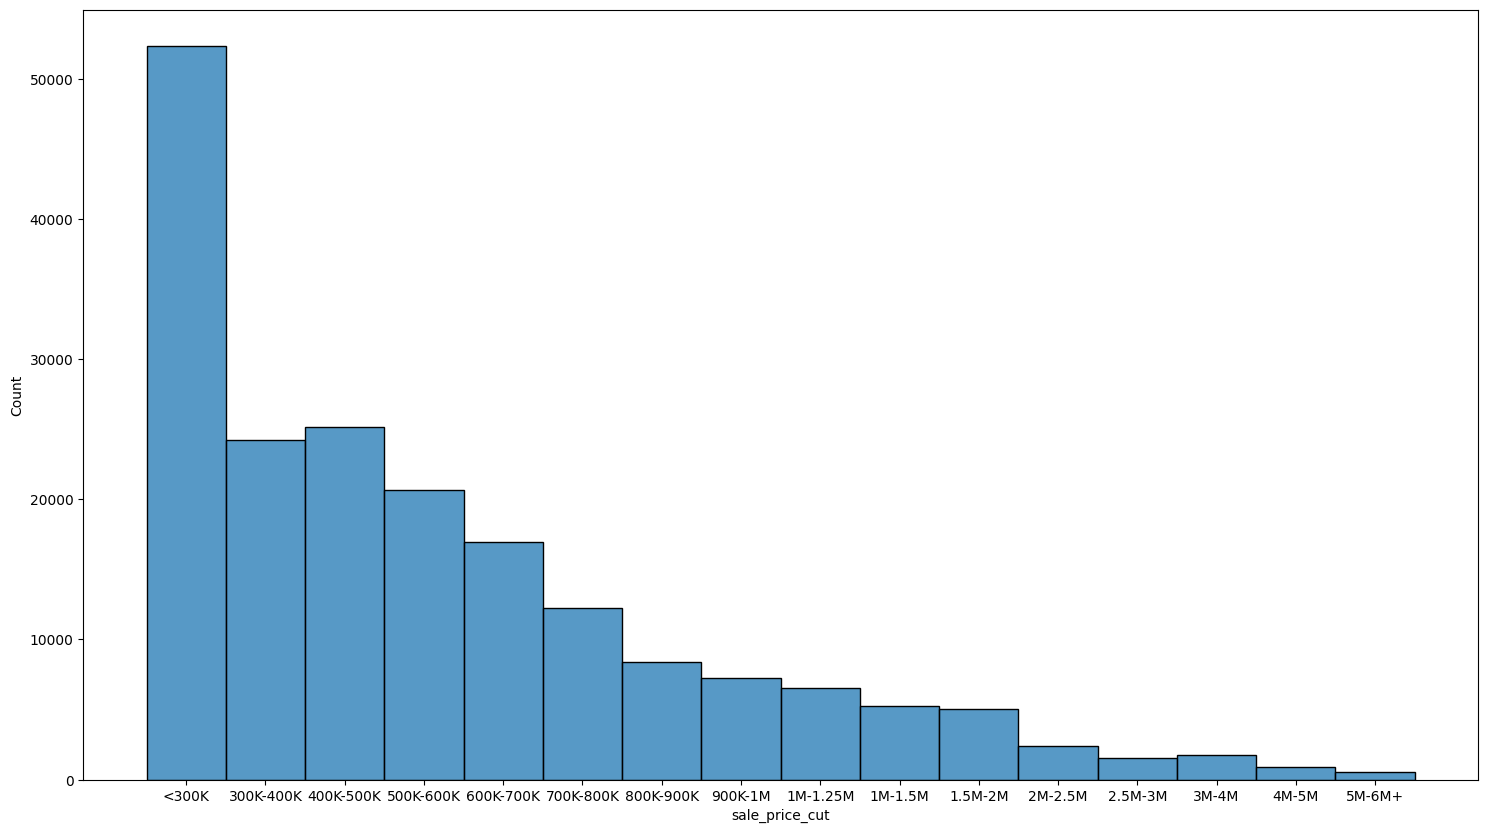

In [24]:
fig, ax = plt.subplots(figsize=(18, 10)) #Creating a larger figure to display the sale_price graph to make it easier to read.
cut_labels_16 = ["<300K", "300K-400K", "400K-500K", "500K-600K", "600K-700K", "700K-800K", "800K-900K", "900K-1M", "1M-1.25M", "1M-1.5M", "1.5M-2M", "2M-2.5M", "2.5M-3M", "3M-4M", "4M-5M", "5M-6M+"] #Creating labels for the new column.
cut_bins = [0, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1250000, 1500000, 2000000, 2500000, 3000000, 4000000, 5000000, 6000000] #Bins are based on Zillow's price points.
df["sale_price_cut"] = pd.cut(df["sale_price"], bins=cut_bins, labels=cut_labels_16) #Creating a new column cut from the previous sales column.
sns.histplot(x=df["sale_price_cut"], ax=ax) #Countplot should be much easier to read now.
df.drop('sale_price_cut', axis=1, inplace=True) #We drop the column that we created after we use it to graph the sale_price data.

**Searching for Outliers: Zip Code**

A map of zip codes in Brooklyn, NY is attached below:
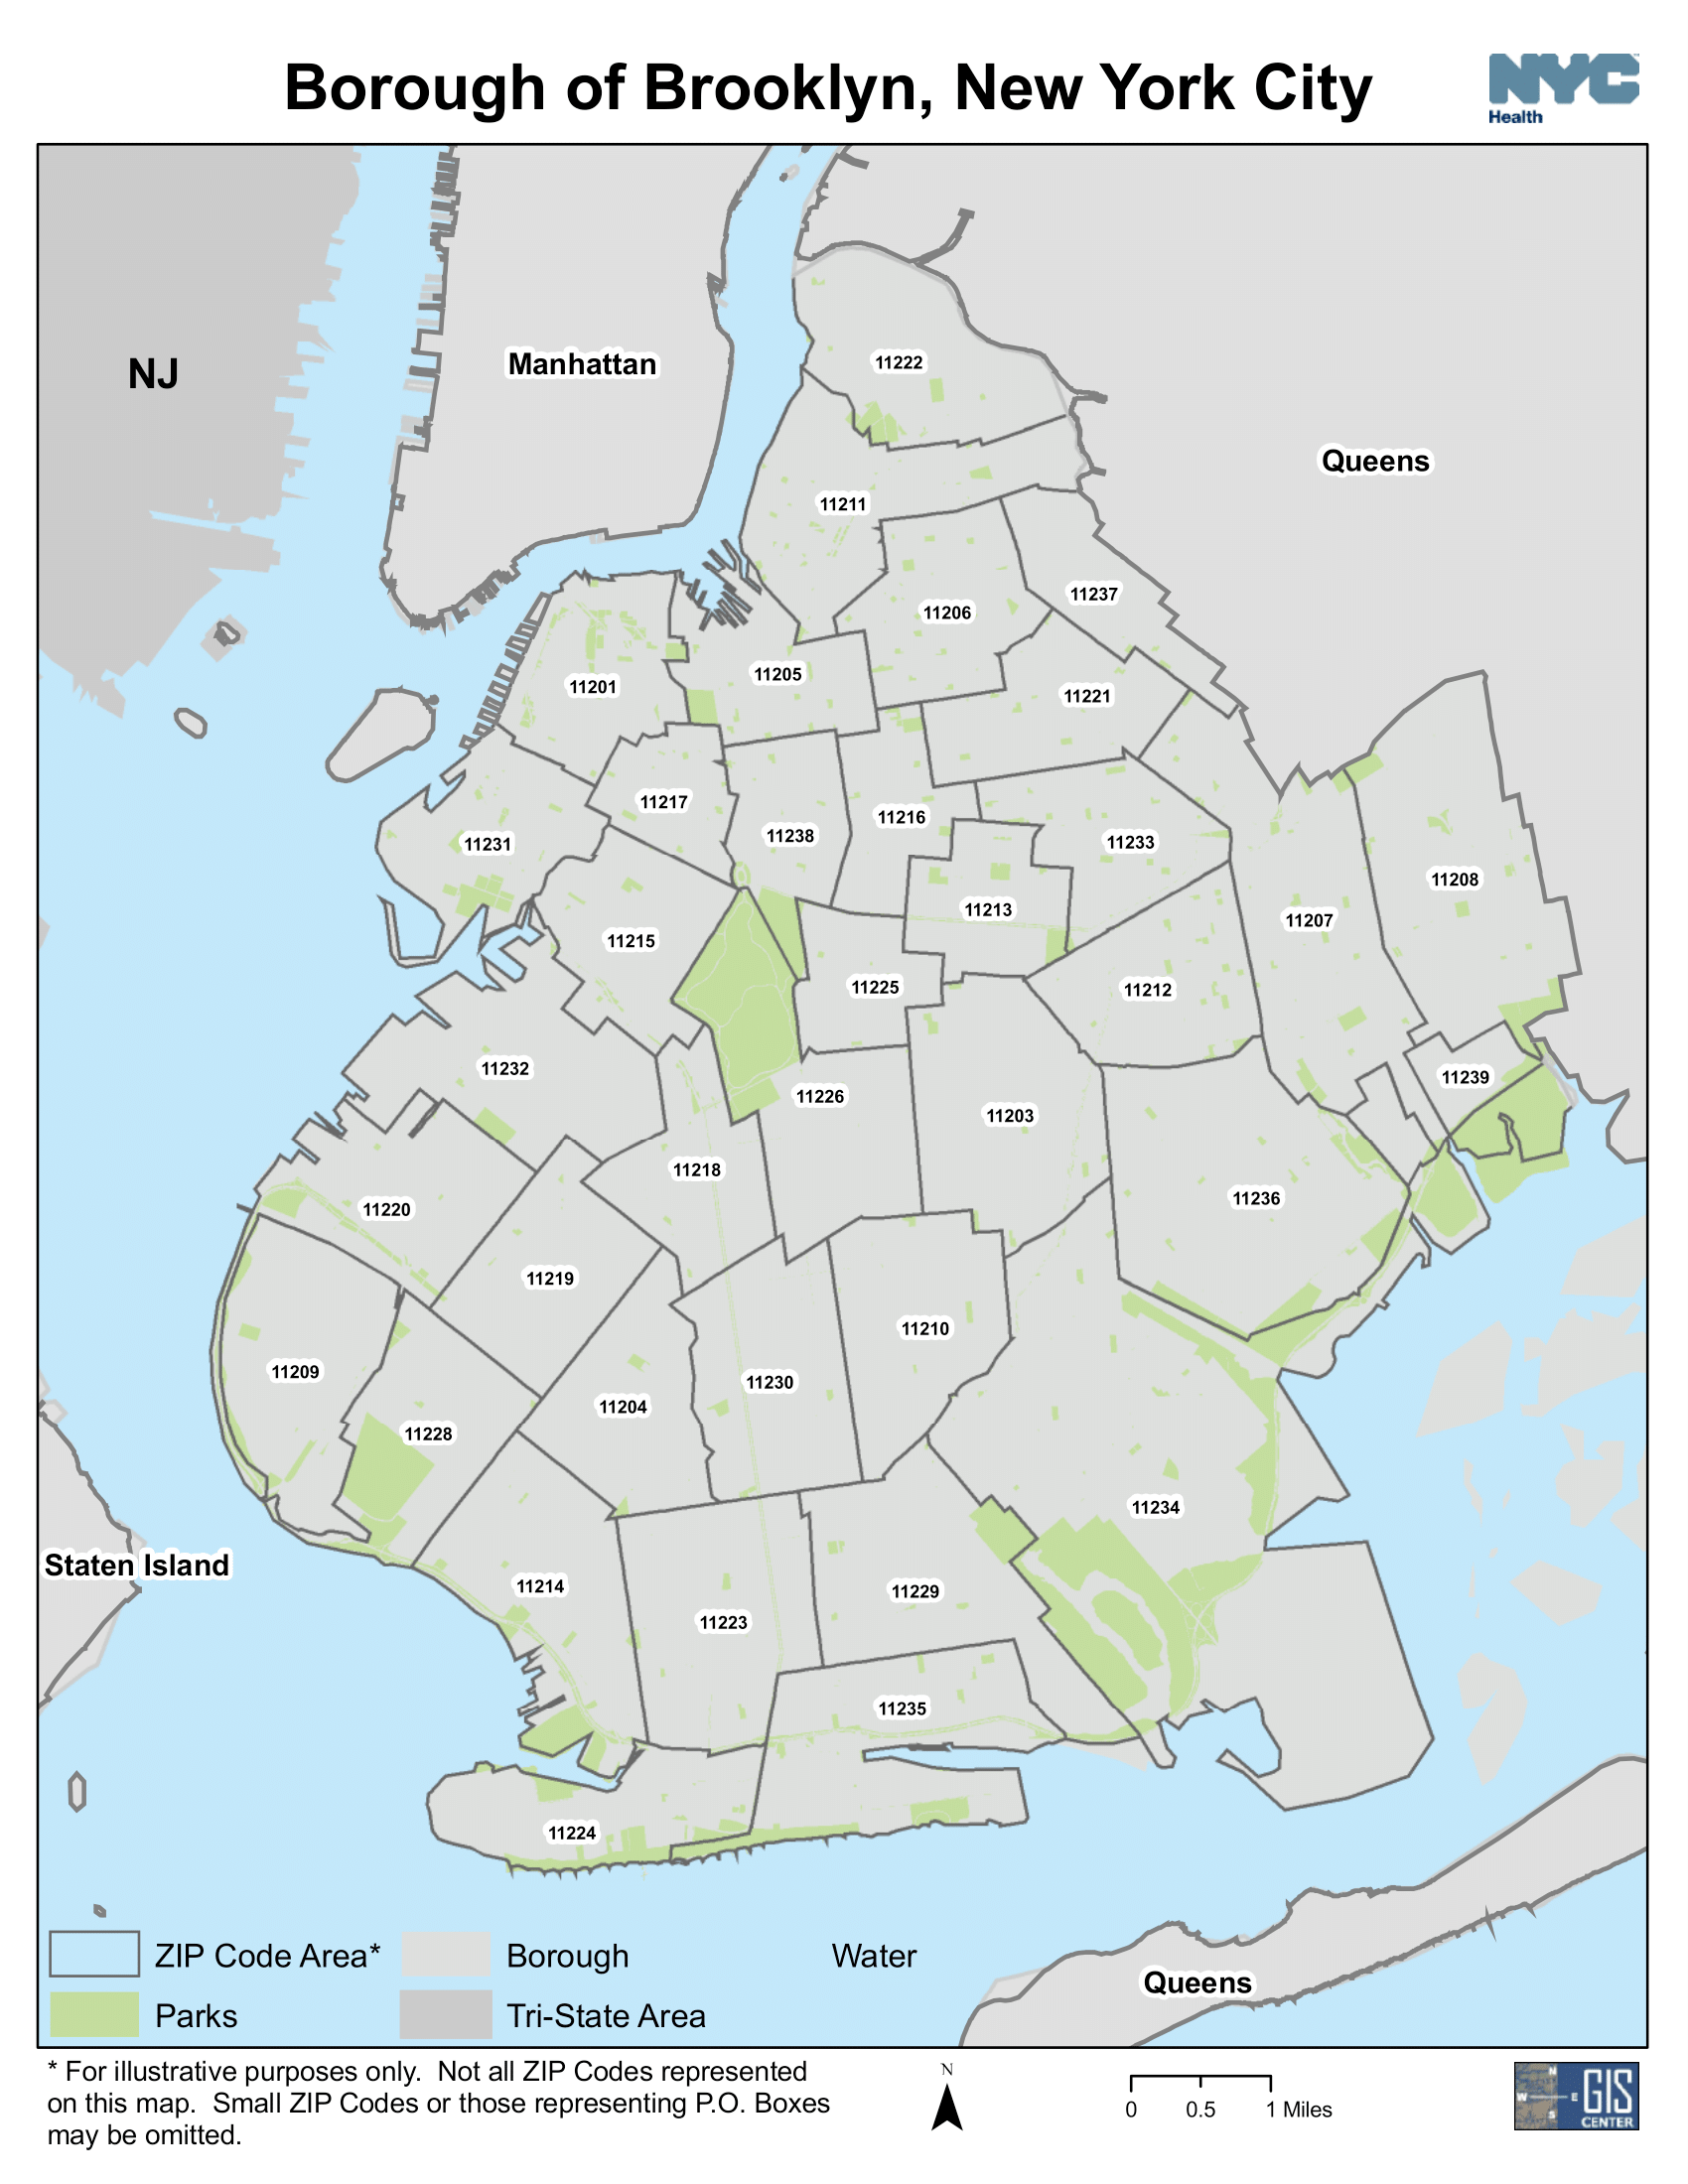

We can see that zip codes in Brooklyn start at 11201 and end at 11256.

In [25]:
#We can use the value_count() function to see how many properties have a zip code value less than 11201 and greater than 11256.

df[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)]["zip_code"].value_counts()

0        196
11416     25
33803      2
11200      1
11258      1
Name: zip_code, dtype: int64

We can map how many times a property with each zip code appears in the data set using Seaborn's countplot() function.

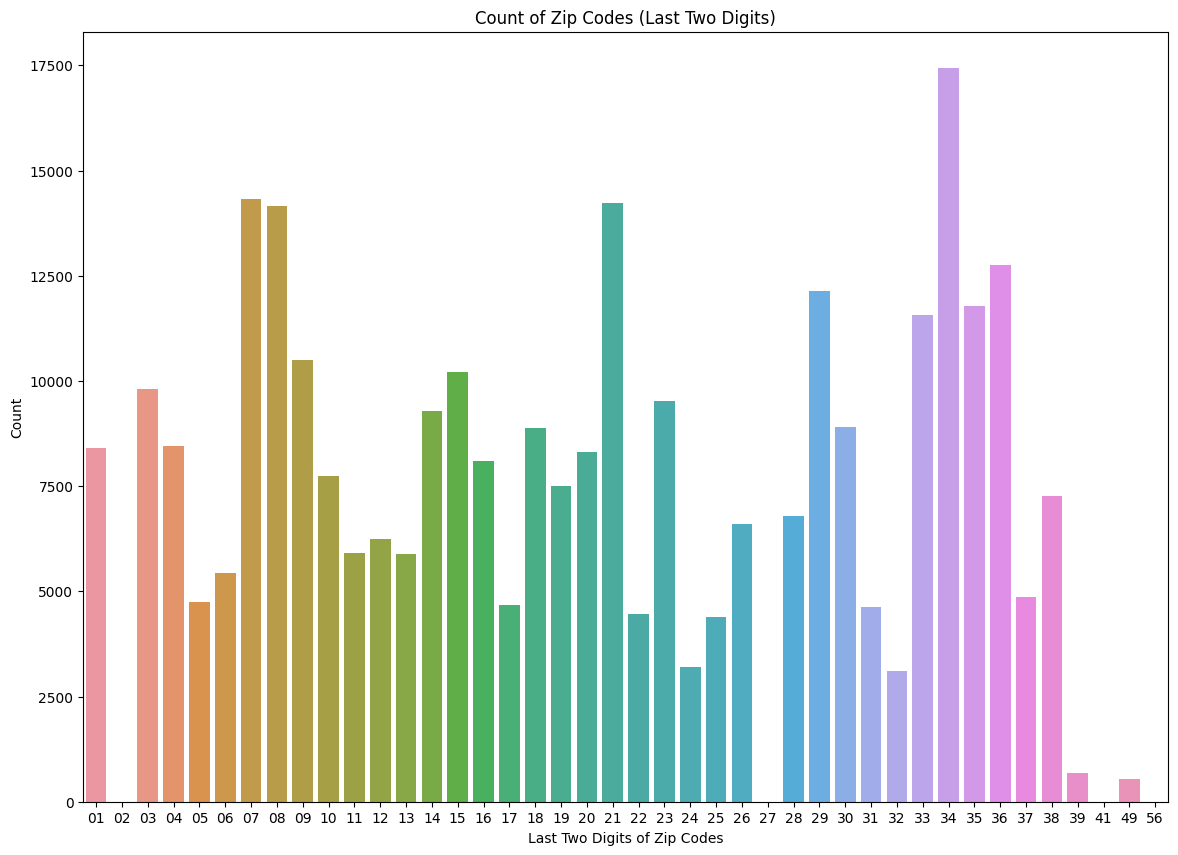

In [26]:
#Let's try to map out how often each zip code actually appears in dataset.

#Removing all the zip codes that are out of range
df.drop(df.index[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)], inplace=True)

# Extract the last two digits of zip codes
df["last_two_digits"] = df["zip_code"].astype(str).str[-2:]

# Get the sorted unique last two digits
sorted_last_two_digits = df["last_two_digits"].unique()
sorted_last_two_digits.sort()

# Set the size of the figure before creating the plot
plt.figure(figsize=(14, 10))

# Create the count plot with the x-axis arranged in order of last two digits
ax = sns.countplot(x="last_two_digits", data=df, order=sorted_last_two_digits)

# Add titles, labels, etc. if needed
plt.title('Count of Zip Codes (Last Two Digits)')
plt.xlabel('Last Two Digits of Zip Codes')
plt.ylabel('Count')

# Display the plot
plt.show()

This category is highly imbalanced, we can use TargetEncoder() with our machine learning model to encode the data so that our XGBoost model can interpret it.

In [27]:
le = LabelEncoder() #Creating a label encoder to convert each zip code to an integer.
df["zip_code_encoder"] = le.fit_transform(df["zip_code"]) #Creating a new column with the newly encoded values.

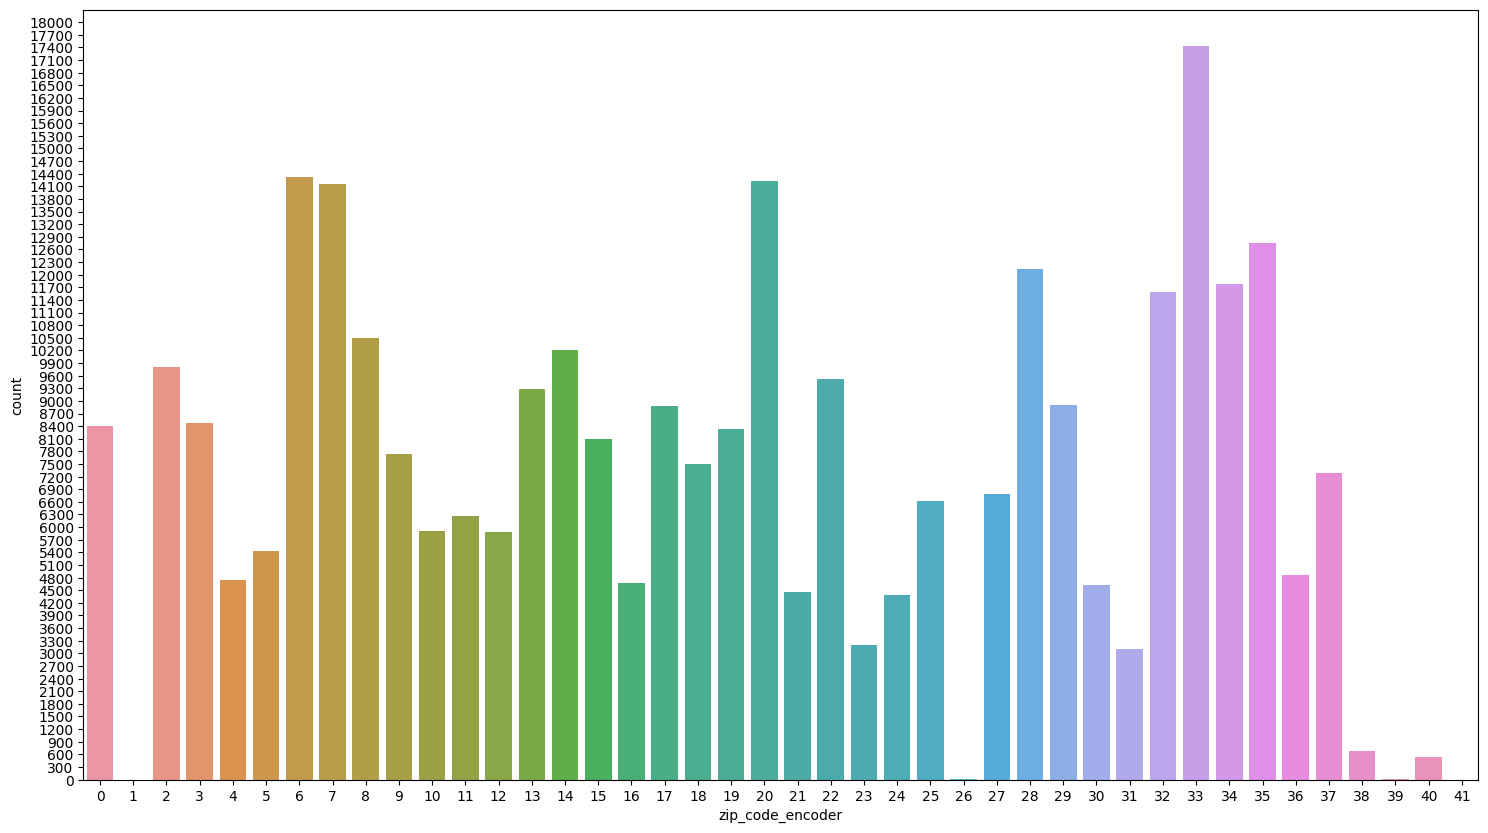

In [28]:
fig, ax = plt.subplots(figsize=(18, 10)) #Creating a larger figure to display the graph.
ax.set_yticks(np.arange(0, len(df["zip_code"]), 300)) #Changing the tick marks because they're a bit too high by default.
sns.countplot(x=df["zip_code_encoder"], ax=ax) #Let's try to map out how often each zip code appears in our dataset.
df.drop('zip_code_encoder', axis=1, inplace=True)

This category is highly imbalanced, even considering the few invalid zip codes that will be dropped later.

We can use TargetEncoder() with our machine learning model to encode the data so that our XGBoost model can interpret it.

**Searching for Outliers: Building Classes**

Each piece of NYC real estate has a building code that dictates what type of real estate it is. Building codes are used for tax and appraisal purposes.

NYC is complicated because people sometimes live in mixed-use real estate.

We can remove further building classes from our dataset by removing classes that are not residential real estate.

NYC publishes a full-list of building codes here. Using their list, we can see that building codes E,F,G,H,I,J,M,M,O,P,Q,T,U,W,Y and Z do not represent residential or mixed-use buildings and instead represent warehouses, factories, government buildings, etc.

We can use Seaborn's countplot() to graph what building classes are in the dataset to find out what we can do to remove outliers further.

In [29]:
def wrangle(df):
    #Dropping properties that are below the 99.7% percentile or the first .21% of the data.
    df.drop(df.index[df["year_built"] < 1910], inplace=True)
    #Droppping all properties less than 644 sqft and greater than 49,400 sqft.
    df.drop(df.index[(df["land_sqft"] < 644) | (df["land_sqft"] > 49400)], inplace=True)
    #Dropping all properties with lots greater than 32,125 square feet.
    df.drop(df.index[df["LotArea"] > 32125.0], inplace=True)
    #Dropping all properties without sale_price data.
    df.drop(df.index[df["sale_price"] == 0], inplace=True)
    #Dropping sale_price outliers based on our graphing.
    df.drop(df.index[(df["sale_price"] < 333000) | (df["sale_price"] > 5000000)], inplace=True)
    #Removing all the zip codes that are out of range
    df.drop(df.index[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)], inplace=True)
    #The value counts are saved in their own Series variable.
    counts = df['building_class_at_sale'].value_counts()
    #We drop all building classes with less than 100 values.
    df.drop(df.index[df['building_class_at_sale'].isin(counts[counts < 100].index)], inplace=True)
    #Drop all building classes that start with a letter from the list.
    df.drop(df.index[df['building_class_at_sale'].str.startswith(('E','F','G','H','I','J','M','N','O','P','Q','T','U','W','Y','Z'))], inplace=True)

In [30]:
wrangle(df) #Calling the data wrangling function we created and passing in the DataFrame.

<Axes: xlabel='building_class_at_sale', ylabel='count'>

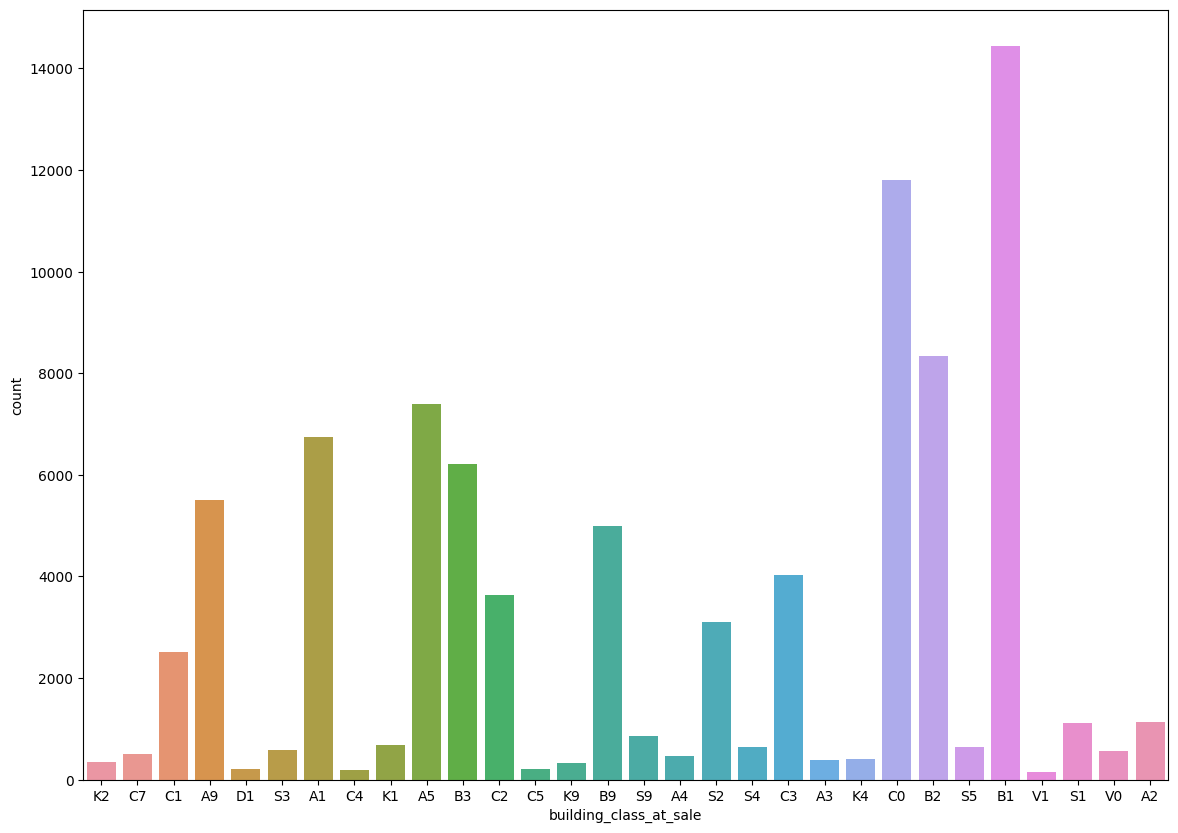

In [31]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.countplot(x=df["building_class_at_sale"], ax=ax) #Mapping out how many time each building class appears in the data set.

In [32]:
!pip install category_encoders

from category_encoders import TargetEncoder
from xgboost import XGBRegressor

#Function to create the machine learning model
def create_model(df):
    #X includes every column except the sale_price column because that's what we're trying to predict.
    X = df.drop('sale_price', axis=1).copy()
    #y represents the column we're trying to predict, the sale price for each property.
    y = df[['sale_price']].copy()
    #We pass in X and y into the train_test_split() function.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    preprocessor = ColumnTransformer(
        transformers=[
            #Target encoding is used on all the categorical features in X: zip_code, year_built,
            # building_class_at_sale, SchoolDist, LotArea, ProxCode, sale_year, sale_month, and sale_day.
            ('target_encoded', TargetEncoder(), [2,4,5,6,8,9,10,11]),
            #We use RobustScaler for both the continious variable features: land_sqft and LotArea.
            ('numeric', RobustScaler(), [3,7])
        ],
        #All other columns are dropped from the model.
        remainder='drop')
    #We use XGBRegressor with the reg:squarederror objective, because we want to create a linear regression model powered by XGBoost.
    xgb_model = XGBRegressor(objective='reg:squarederror')

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb_model)
    ])
    #Training our model using the X_train and y_train data.
    pipeline.fit(X_train, y_train)
    #We return the pipeline, X_test, and y_test objects.
    return pipeline, X_test, y_test

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 905.7 kB/s eta 0:00:00


In [33]:
#We call the create_model function and pass the returned objects into the pipeline, X_test, and y_test variables.
pipeline, X_test, y_test = create_model(df)

In [34]:
#y_pred saves the predicted output from the model given or test data input.
y_pred = pipeline.predict(X_test)

# Mutual Information

In [35]:
X_MI = df.copy()
y_MI = X_MI.pop("sale_price")

# Label encoding for categoricals
for colname in X_MI.select_dtypes("object"):
    X_MI[colname], _ = X_MI[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X_MI.dtypes == int

In [36]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_MI, y_MI, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

address       0.356172
SchoolDist    0.172409
LotArea       0.122506
ProxCode      0.056808
sale_day      0.002602
Name: MI Scores, dtype: float64

A bar plot to make comparisions easier:

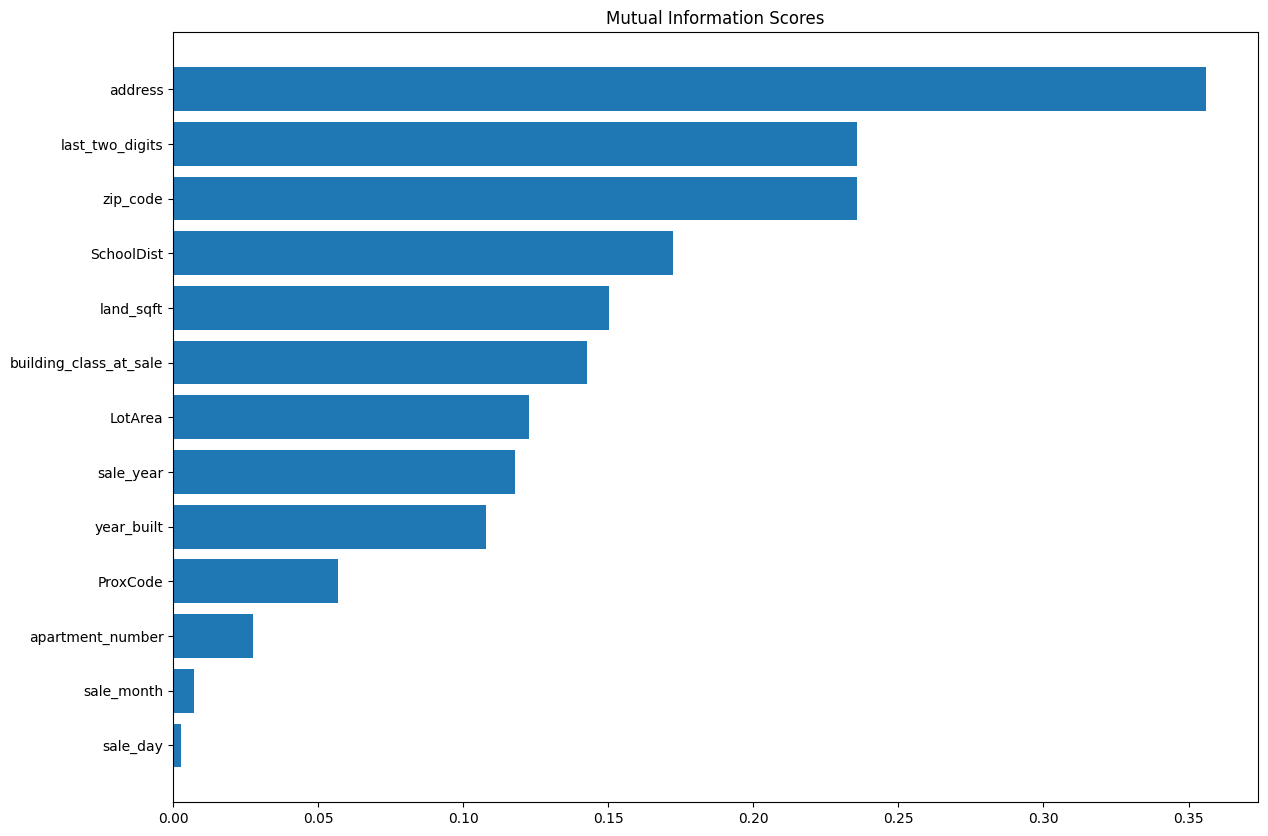

In [37]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(14, 10))
plot_mi_scores(mi_scores)

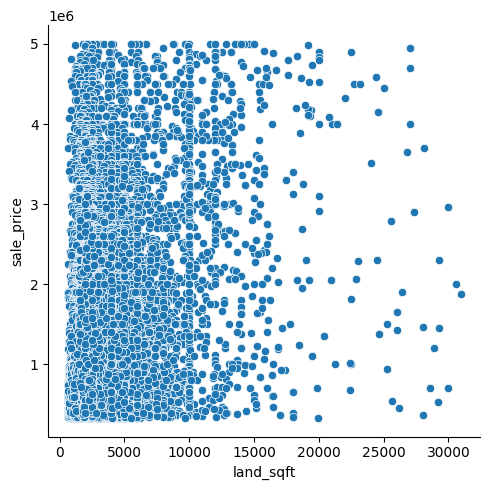

In [38]:
sns.relplot(x="land_sqft", y="sale_price", data=df);

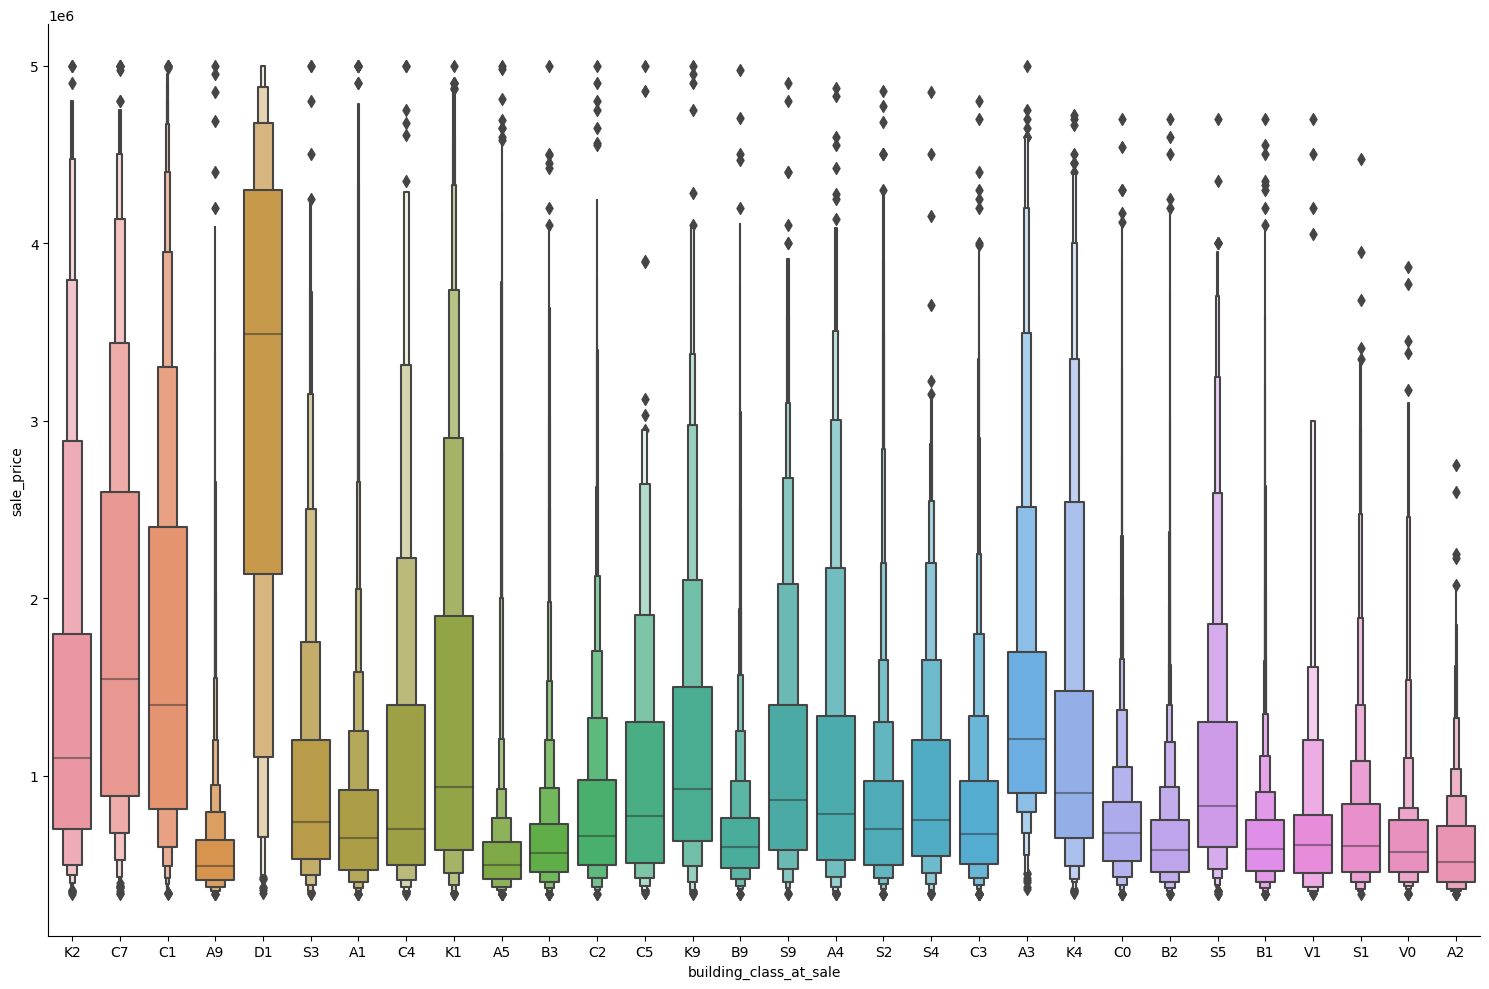

In [39]:
sns.catplot(x="building_class_at_sale", y="sale_price", data=df, kind="boxen", height=10, aspect=1.5);

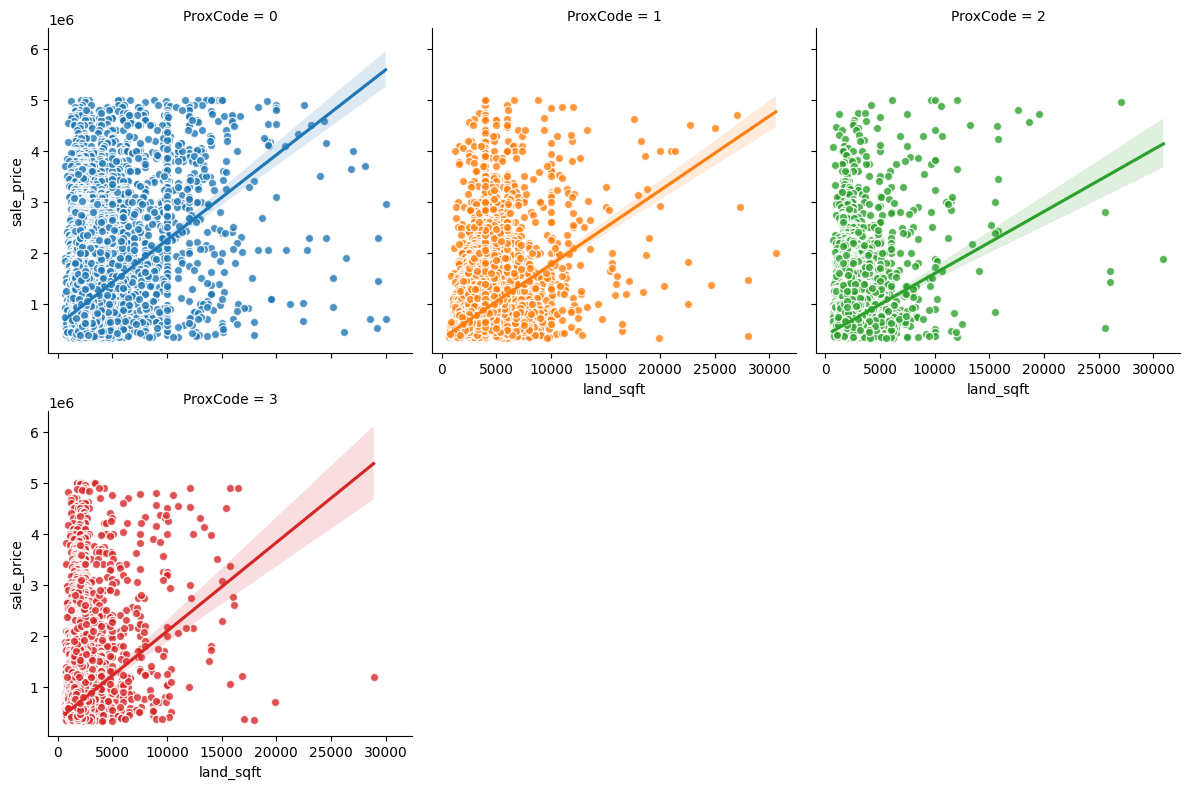

In [40]:
feature = "land_sqft"

sns.lmplot(
    x=feature, y="sale_price", hue="ProxCode", col="ProxCode",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

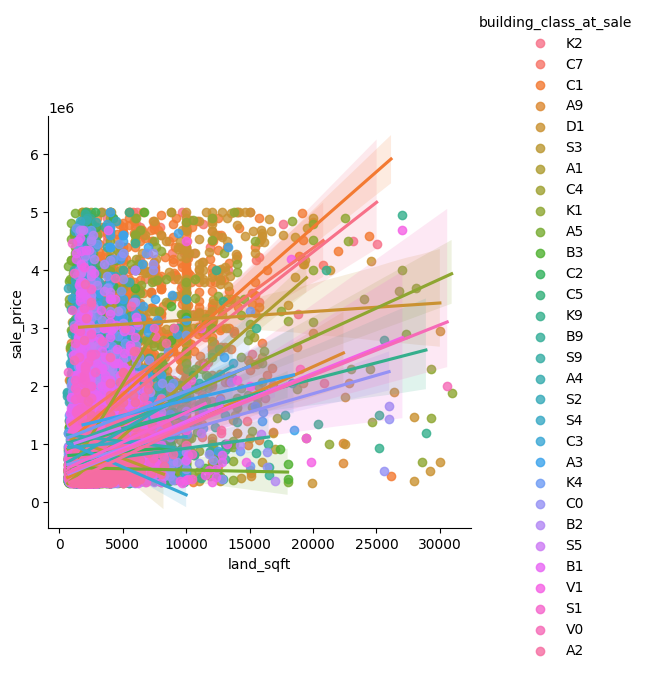

In [41]:
sns.lmplot(x="land_sqft", y="sale_price", hue="building_class_at_sale", data=df);

# Principal Component Analysis

In [42]:
df.head()

,address,apartment_number,zip_code,land_sqft,year_built,building_class_at_sale,sale_price,SchoolDist,LotArea,ProxCode,sale_year,sale_month,sale_day,last_two_digits
2455,1756 86TH STREET,NaN,11214,9666,1920,K2,5000000.0,20,9666.0,2,2010,7,1,14
2456,801 70 STREET,50,11228,15000,1926,C7,5000000.0,20,15000.0,0,2010,6,24,28
2462,1580 PRESIDENT STREET,NaN,11213,8800,1916,C1,5000000.0,17,8800.0,0,2011,4,4,13
2465,14 COLLEGE PLACE,NaN,11201,2050,1920,A9,5000000.0,13,2050.0,3,2012,12,31,01
2468,305 EAST 34TH STREET,42,11203,10000,1936,D1,5000000.0,17,10000.0,2,2012,4,24,03


In [43]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

features = [
    "land_sqft",
    "year_built",
    "LotArea",
    "sale_year",
]


X_upca = df.copy()
y = X_upca.pop("sale_price")
X = X_upca.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                 PC1       PC2       PC3       PC4
land_sqft   0.706771 -0.021203 -0.004180 -0.707112
year_built  0.026271  0.704939  0.708780  0.000931
LotArea     0.706760 -0.021601 -0.005641  0.707101
sale_year  -0.016557 -0.708622  0.705394  0.000530


In [44]:
from sklearn.model_selection import cross_val_score
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)

    return score



X = df.copy()

filtered_data = X.dropna(subset=['land_sqft', 'year_built', 'LotArea', 'sale_year'])

y = filtered_data.pop("sale_price")

X["Feature1"] = X.land_sqft + X.LotArea
X["Feature2"] = X.year_built * X.LotArea

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.04056 RMSLE


# Evaluating our Model: Getting the R-squared Score

Our model works! Next, we have to have some way of checking to see how well the linear regression model fits the data. We can use R-squared as a simple way of evaluating the model.

R-squared is a percentage in variance in the independent variable that the dependent variables collectively explain.

R-squared measures goodness-of-fit for a prediction model using a standardized scale.

Scikit-learn includes the r2_score function that generates an R-squared score for our model based on two values, y_test and y_pred. Y_test represents the true sale_price data from our data set, and y_pred represents the predicted sale_price values using our prediction model.

After we generate an R-squared score, we can use Seaborn to generate a regression plot for the data.

In [45]:
#We generate the r2 score by passing in the the y_test, the actual sale_price data from the .csv, and y_pred, the predicted sale_price values.
r2 = r2_score(y_test, y_pred)
print(r2)

0.6386024273312668


[Text(0.5, 0, 'Predicted Sales Price'), Text(0, 0.5, 'True Sale Price')]

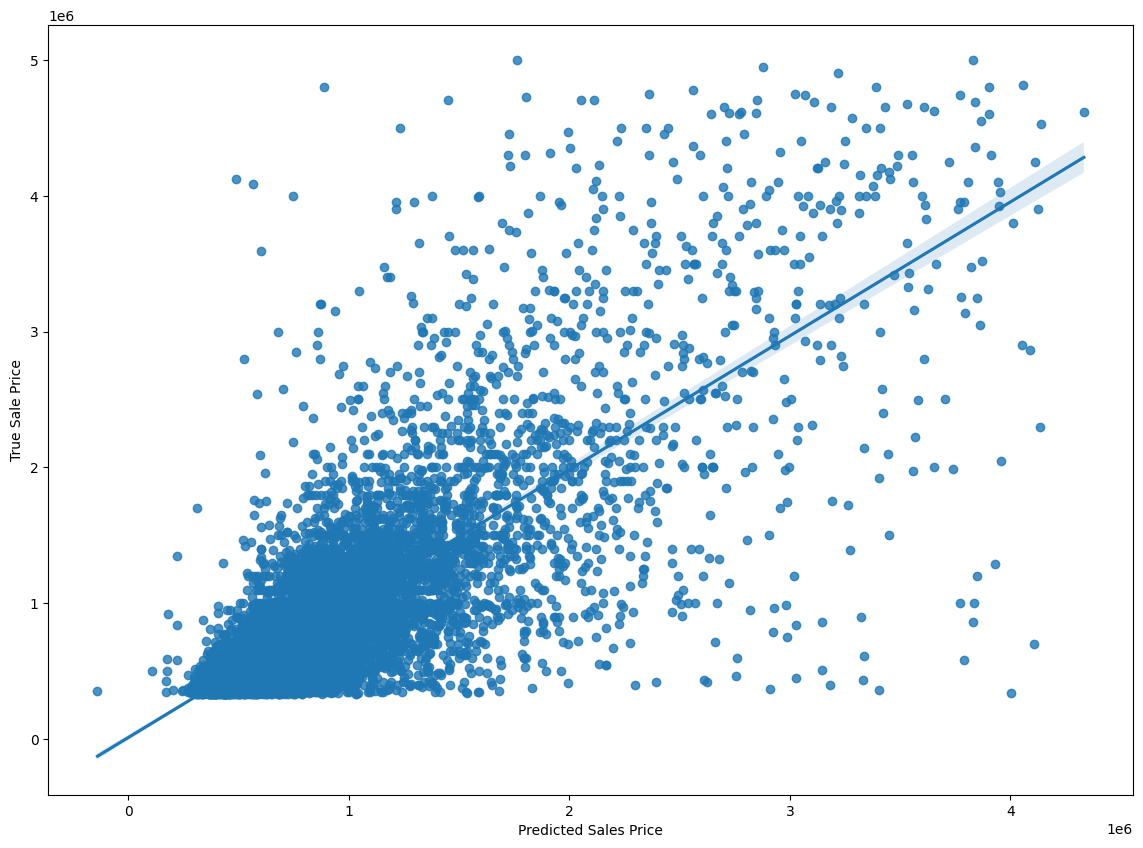

In [46]:
fig, ax = plt.subplots(figsize=(14, 10)) #Creating a larger figure to display the regression plot.
sns.regplot(x=y_pred, y=y_test, ax=ax).set(xlabel='Predicted Sales Price', ylabel='True Sale Price')

# Evaluating our Model: Getting the Root Mean Square Error
While R-squared measures goodness-of-fit, root mean square error, also known as RMSE, measures how accurate the predictions are. It does this by measuring the average difference between the model's predicted values and the actual values.

RMSE is similar to mean squared error, but because the errors, the difference between the predicted values and the actual values, are squared before they are average, RMSE gives high weight to larger errors. Essentialy. RMSE punishes inaccuracy more making innacurate prediction models more obvious.

Before we can generate the RMSE for our mnodel, we need a baseline value to compare it too. We can use the mean of the test data as a naive model to pass into the RMSE function. The RMSE of the machine learning model should be better than just picking the average each time for a prediction.

Scikit-learn can generate RMSE for the model as part of the sklearn.metrics package.

In [47]:
#We create a baseline DataFrame so we can pass it into the mean_squared_error function to get a baseline value for RMSE.
baseline = y_test.copy()
baseline['sale_price'] = y_test['sale_price'].mean() #This replaces all the sale price values with their mean
baseline['sale_price']

35567    771768.090646
8526     771768.090646
42701    771768.090646
33792    771768.090646
62571    771768.090646
             ...      
66621    771768.090646
50441    771768.090646
41978    771768.090646
78257    771768.090646
99037    771768.090646
Name: sale_price, Length: 17618, dtype: float64

In [48]:
#We use the baseline DataFrame in order to get a baseline RMSE value.
baseline_rmse = mean_squared_error(y_test, baseline)
print(baseline_rmse)

316701030633.36957


In [49]:
#Generating the RMSE for the machine learning solution.
rmse = mean_squared_error(y_test, y_pred)
print(rmse)
#We can see that the machine learning solution is 285% more accurate than just selecting the average value each time.
print(f'{round(((baseline_rmse/rmse) * 100), 2)}')

114454983732.58586
276.7


# Predicting Sale Price Using Data
Now that we have a perfectly good machine learning model, we can pass in user input so that a user can get a sales price prediction for their property. We can use a function to get user input using Python print statements and Python's input() function to save the data into multiple variables. We can replace the first row in the X_test data set with the values the user inputs and then use the pipeline object we created earlier to predict sales data.

Non-descriptive Method
Non-descriptive method or predictive methods involve using the data to say something about future behavior.

The predicted sale's price data is an example of a non-descriptive method.

Descriptive Method
Descriptive methods summarize the data at hand so that meaningful points can be taken into consideration.

We can use the mean property value for the given user zip code as an example of a descriptive method.

In [50]:
def get_sale_price(X_test):
    print("Welcome to the price prediction algorithm.")
    print("This algorithm can help you appraise the value of property in Brooklyn.")
    address = input("Type in your street address: ")
    zip_code = input("Type in your zip code: ")
    land_sqft = input("Type in the approximate usable square footage of the property: ")
    year_built = input('Type in the year the property was built: ')
    LotArea = input('Type in the square footage of the lot area for the property:')
    ProxCode = input('Type in 1, 2 or 3 if your property is detached, semi-attached, or attached: ')
    #We replace the first row in X_test with the user's data.
    X_test.iloc[[0],[0,2,3,4,5,6,7,8]] = [address, zip_code, land_sqft, None, None, year_built, LotArea, ProxCode]
    #We use the .format function to return the sale's price using commas and rounded to the second decimal point.
    print('The predicted value for your property is ${:,.2f}'.format(pipeline.predict(X_test)[0]))
    #We use the same .format() function with the mean sale's price data.
    print(f'The mean property value for the zip code {zip_code} is: ' + '${:,.2f}'.format(df.loc[df['zip_code']==int(zip_code), 'sale_price'].mean()))

In [51]:
get_sale_price(X_test)

Welcome to the price prediction algorithm.
This algorithm can help you appraise the value of property in Brooklyn.
Type in your street address: 85 JAY STREET	
Type in your zip code: 11201
Type in the approximate usable square footage of the property: 200
Type in the year the property was built: 1995
Type in the square footage of the lot area for the property:300
Type in 1, 2 or 3 if your property is detached, semi-attached, or attached: 2
The predicted value for your property is $930,876.31
The mean property value for the zip code 11201 is: $2,179,443.02
